In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from image_patching import *

First, we create the dataframe using the dataset CBIR 15.


In [2]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]

Now we are going to work with 2 similar environments
In order to do that, we select 2 environments that are quite similars from the dataframe. In this case, we're getting the "Bedroom" and "LivingRoom".

In [3]:
df_similar = df[df['category'].isin(['Bedroom', 'Forest'])]
df_similar

image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
1950  ../data/CBIR_15-Scene/06/1951.jpg   Forest
1951  ../data/CBIR_15-Scene/06/1952.jpg   Forest
1952  ../data/CBIR_15-Scene/06/1953.jpg   Forest
1953  ../data/CBIR_15-Scene/06/1954.jpg   Forest
1954  ../data/CBIR_15-Scene/06/1955.jpg   Forest

[544 rows x 2 columns]

Now we split both of them into train and test sets.
This will give us some images for training the PCAs and test images to see if it's possible to predict the currently environment with the pretrained PCA.

In [4]:
X = df_similar['image_path']
y = df_similar['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


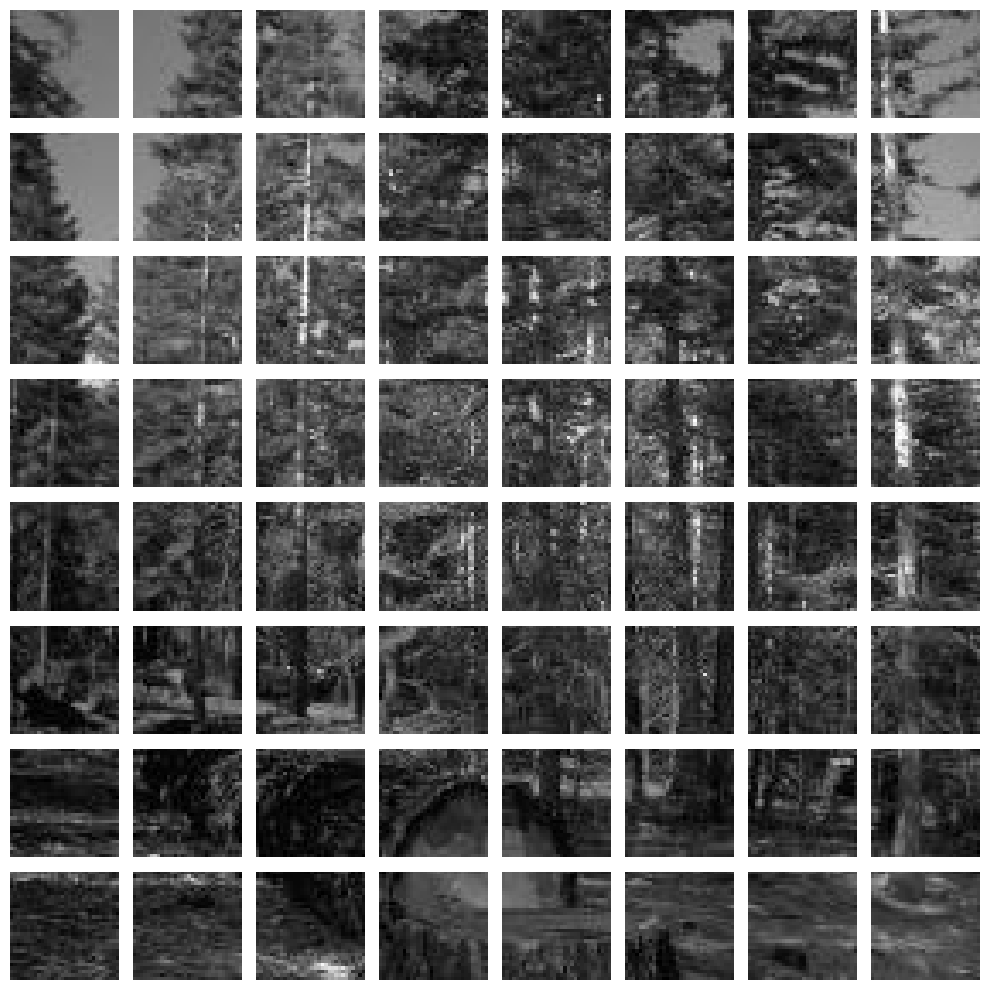

In [5]:
# Função para criar a grid de patches
def plot_patches_grid(patches, patch_size, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    patch_idx = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if patch_idx < len(patches):
                axes[i, j].imshow(cv2.cvtColor(patches[patch_idx], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
                patch_idx += 1
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

patch_size = (32,32)

# Carregar a primeira imagem de treino e criar os patches
first_image_path = X_train.iloc[0]
image = cv2.imread(first_image_path)
resized_image = resize_image(image, standard_size)
patches, positions = create_patches(resized_image, patch_size)

# Determinar o número de patches na grid
grid_rows = resized_image.shape[0] // patch_size[0]
grid_cols = resized_image.shape[1] // patch_size[1]

# Plotar a grid de patches
plot_patches_grid(patches, patch_size, (grid_rows, grid_cols))


We can see that the previous function has correctly separated our image into patches and we are looking at the first image of the training set (in this case, it's located on the "Bedroom" environment).
So now, we create a function to separate our dataset into patches of 32x32 to all of the training and test datasets.

In [6]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

# Preprocessing/ Training phase

First, we need to get the patches of our training dataset:

In [7]:
patches_by_category = load_patches_by_category('patches_train', y, patch_size)

After that, we its essential to normalize the patches in order to use the PCA without getting misleading information by noises and problems with incorrect variance calculations.

In [8]:
from sklearn.preprocessing import StandardScaler

def normalize_patches(patches, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        normalized_patches = scaler.fit_transform(patches)
    else:
        normalized_patches = scaler.transform(patches)
    return normalized_patches, scaler


normalized_patches_by_category = {}
scalers_by_category = {}
for category, patches in patches_by_category.items():
    normalized_patches, scaler = normalize_patches(patches)
    normalized_patches_by_category[category] = normalized_patches
    scalers_by_category[category] = scaler

In [9]:
from sklearn.decomposition import PCA
def apply_pca_and_visualize(patches_by_category, n_components=1024):
    pca_by_category = {}
    num_components_99_dict = {}
    for category, patches in patches_by_category.items():
        print(patches)
        if patches.size == 0:
            continue 
        
        pca = PCA(n_components=n_components)
        pca.fit(patches)
        components = pca.components_
        variance = pca.explained_variance_
        
        fig, axes = plt.subplots(16, 20, figsize=(20, 16))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(components[i].reshape(32, 32), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'{n_components} Principal Components  - Category: {category}')
        plt.show()
        
        # Plotar a log-variância dos componentes principais
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(variance))
        plt.title(f'Log-Variace of Principal Components - Category: {category}')
        plt.xlabel('Index of the Principal Component')
        plt.ylabel('Log-Variance')
        plt.grid(True)
        plt.show()

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

        pca = PCA(n_components=num_components_99)
        pca.fit(patches)

        pca_by_category[category] = pca
        num_components_99_dict[category] = num_components_99

        print("Category: " + category)
        print("Number of components that explain 99% of variance: " + str(num_components_99))

    
    min_num_components = min(num_components_99_dict.values())
    return pca_by_category,num_components_99_dict, min_num_components

In [29]:
from sklearn.decomposition import PCA
# Aplicar PCA para cada categoria e visualizar componentes
def apply_pca_and_visualize(patches_by_category, n_components=1024):
    pca_by_category = {}
    num_components_99_dict = {}
    for category, patches in patches_by_category.items():
        print(patches)
        if patches.size == 0:
            continue  # Pular se não houver patches para esta categoria
        
        #patches = impute_nans(patches)

        # Normalizar patches
        #patches = normalize_patches(patches)
        
        pca = PCA(n_components=n_components)
        pca.fit(patches)
        components = pca.components_
        variance = pca.explained_variance_
        
        # Plotar os 320 primeiros componentes principais
        fig, axes = plt.subplots(16, 20, figsize=(20, 16))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(components[i].reshape(32, 32), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'{n_components} Principal Components  - Category: {category}')
        plt.show()
        
        # Plotar a log-variância dos componentes principais
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(variance))
        plt.title(f'Log-Variace of Principal Components - Category: {category}')
        plt.xlabel('Index of the Principal Component')
        plt.ylabel('Log-Variance')
        plt.grid(True)
        plt.show()

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

        #We take the PCA with the minimum significant components
        pca = PCA(n_components=num_components_99)
        pca.fit(patches)

        pca_by_category[category] = pca
        num_components_99_dict[category] = num_components_99

        print("Category: " + category)
        print("Number of components that explain 99% of variance: " + str(num_components_99))

    
    min_num_components = min(num_components_99_dict.values())
    return pca_by_category,num_components_99_dict, min_num_components

[[-0.03634141 -0.1805135  -0.41152455 ...  0.57496341  0.55540507
   0.53773585]
 [ 1.88668565  1.81823632  1.89040735 ...  0.25410052  0.20461656
   0.1290737 ]
 [-1.34962819 -1.43956851 -1.59402381 ... -1.44188905 -1.47306761
  -1.47530363]
 ...
 [ 0.54213014  0.55918132  0.55024152 ...  0.05547111  0.03684814
   0.02312426]
 [ 1.82414818  1.58216351  0.6290748  ... -0.63209223 -0.5884705
  -0.44608043]
 [ 0.8860862   0.0712975  -0.14349138 ... -0.35706689 -0.39019874
  -0.41580916]]


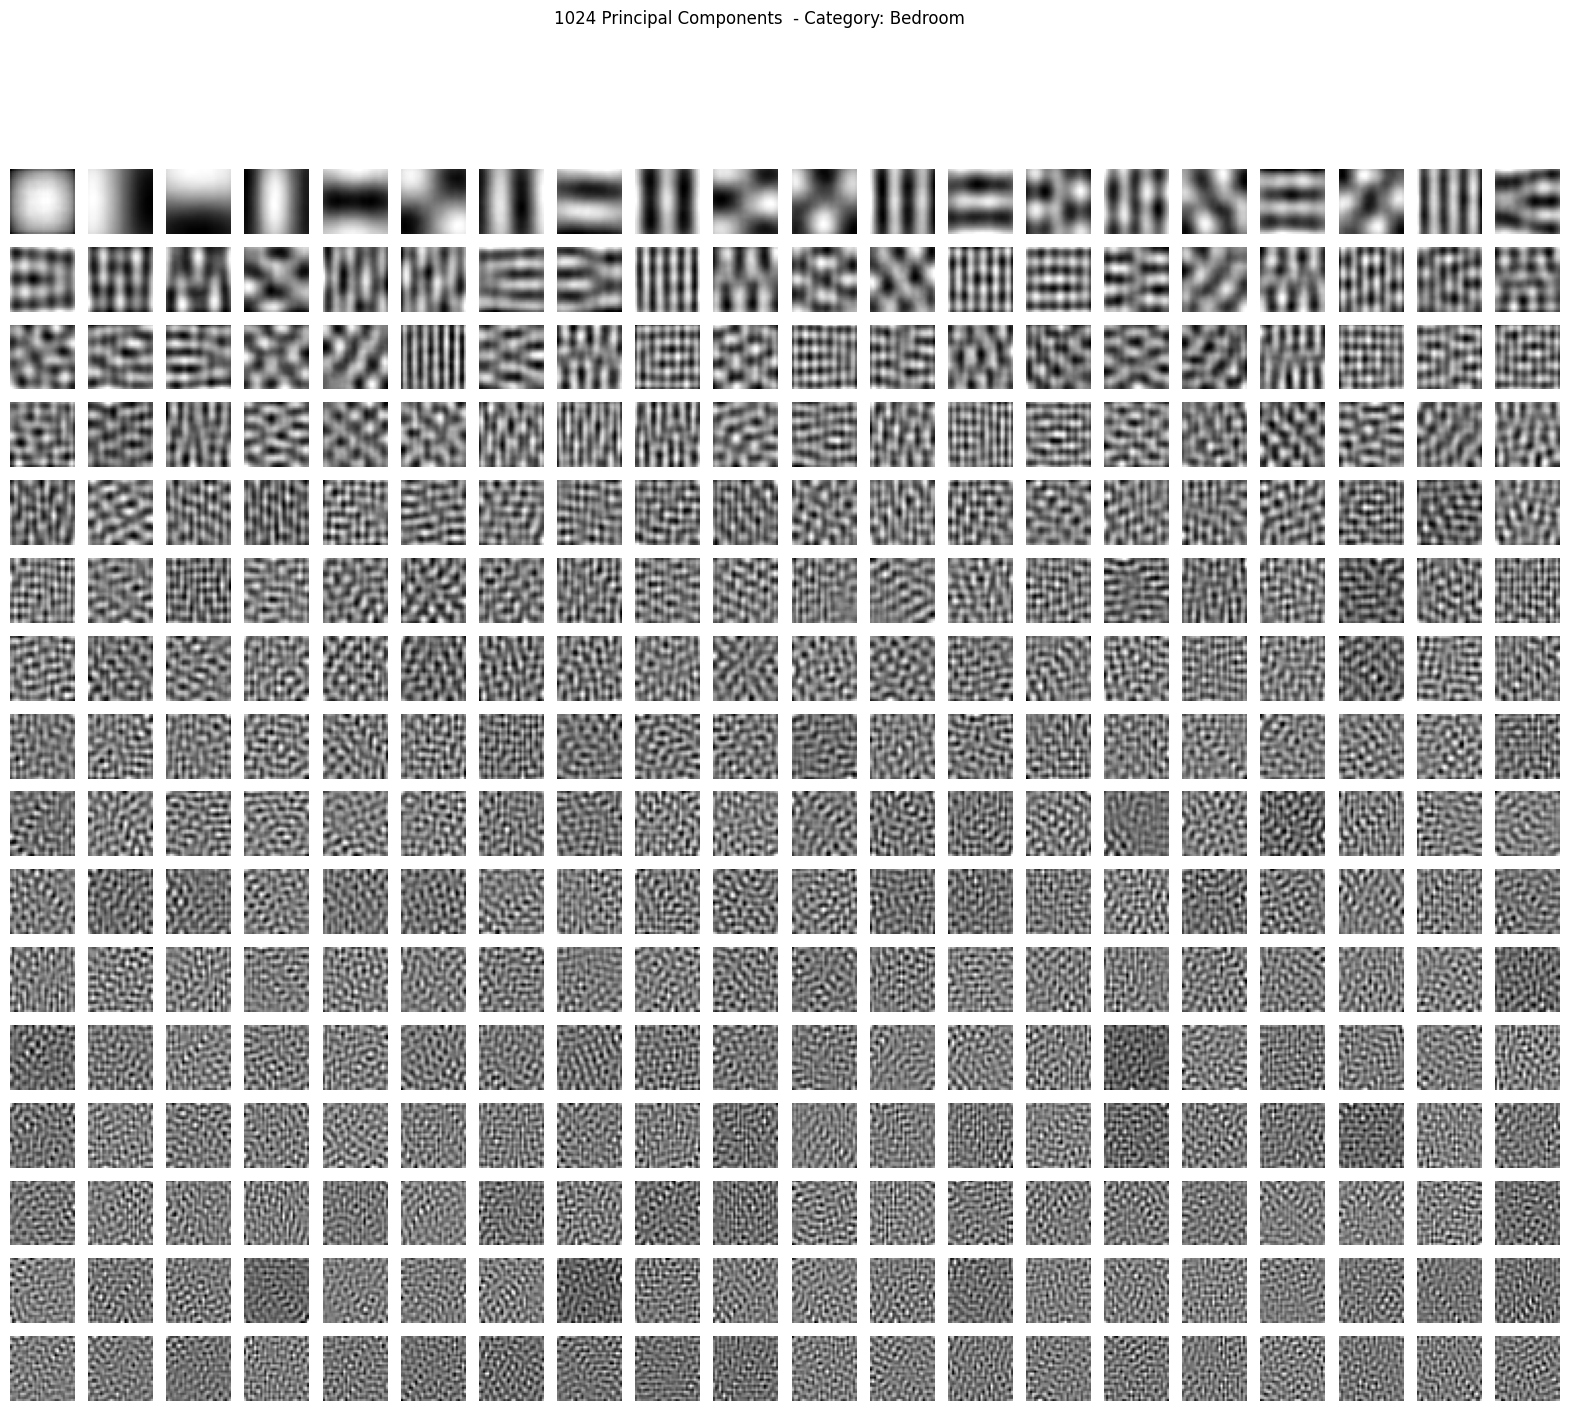

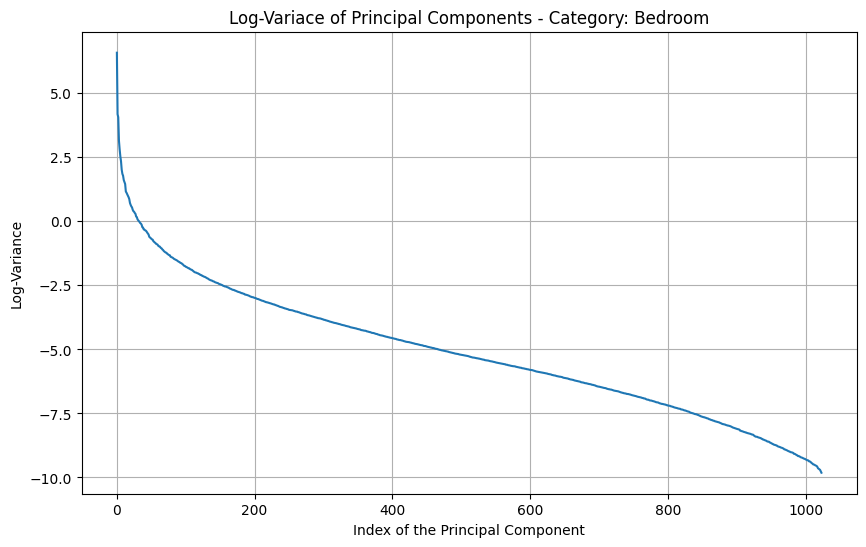

Category: Bedroom
Number of components that explain 99% of variance: 145
[[ 0.12444129 -0.32899402  0.52171967 ...  0.77645902  0.62862044
   0.99785019]
 [-1.12840223 -1.18768381 -1.1150633  ...  1.73907215  1.32464762
   1.11236043]
 [ 1.34474343  1.55040251  1.23477364 ...  1.22457203  1.58980084
   1.71762883]
 ...
 [-1.20975571 -1.07427195 -1.06644599 ... -1.33133181 -1.44288905
  -1.48865783]
 [-1.30737988 -1.46311261 -1.56882492 ... -1.58028348 -1.4760332
  -1.30871317]
 [-0.9006125  -0.68543129 -0.20754007 ... -0.38531545 -0.64742941
  -1.24327875]]


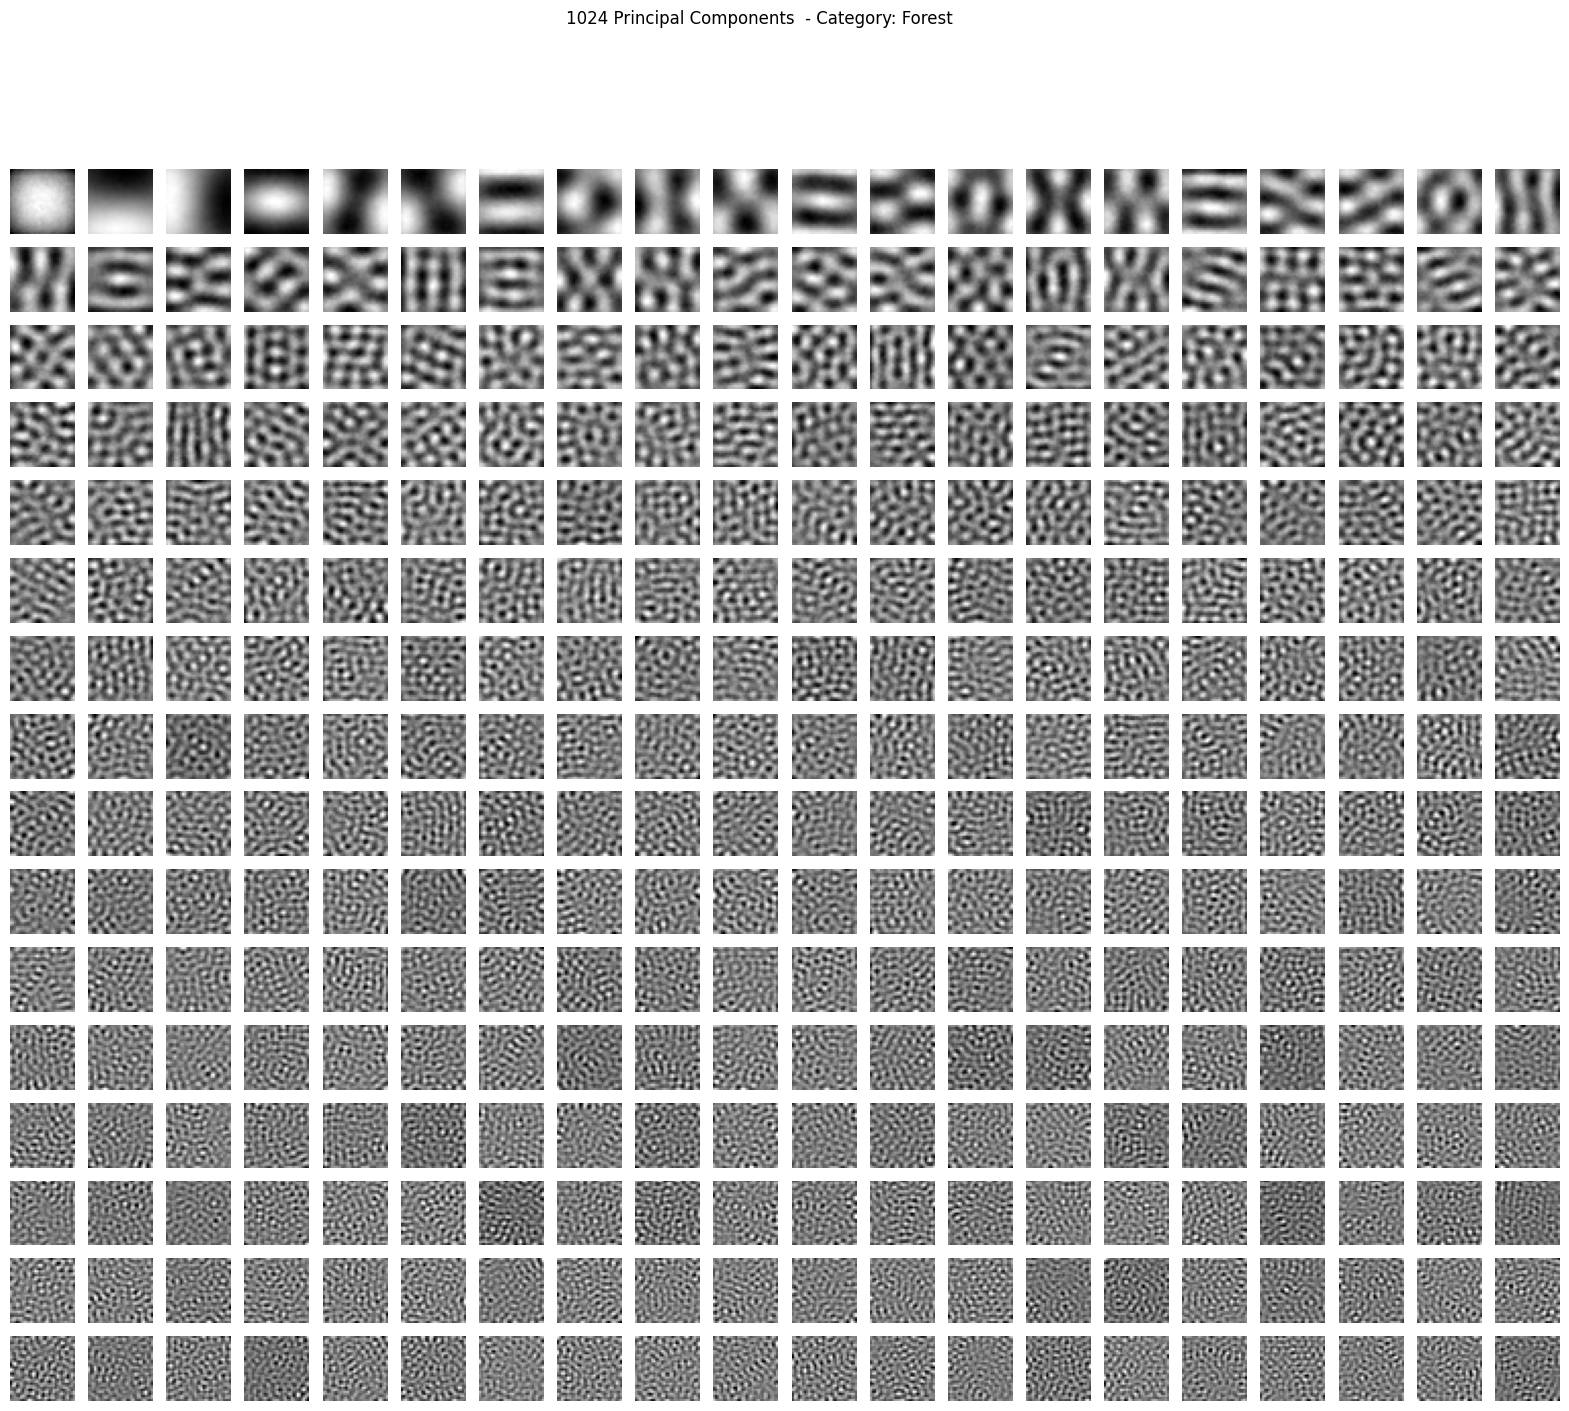

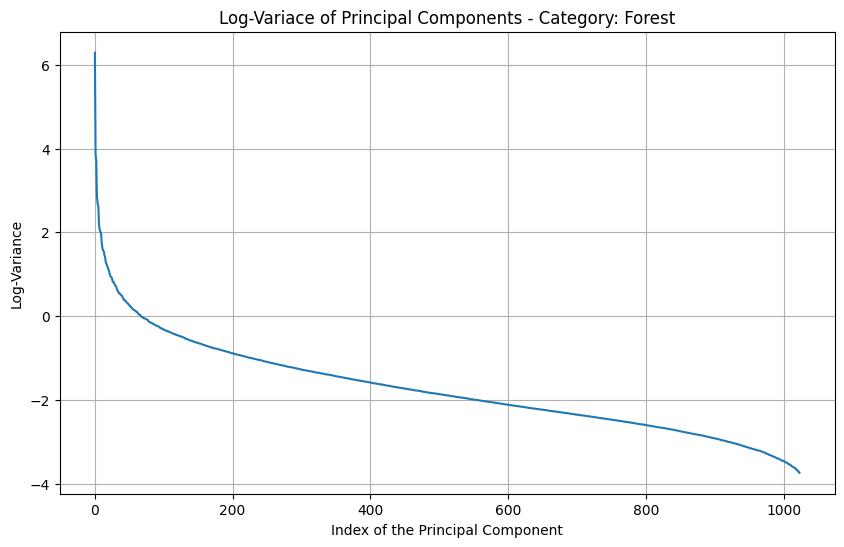

Category: Forest
Number of components that explain 99% of variance: 816
{'Bedroom': PCA(n_components=145), 'Forest': PCA(n_components=816)}


In [30]:
pca_by_category, nummin_components_99_dict, min_components = apply_pca_and_visualize(normalized_patches_by_category)
print(pca_by_category)

Category: Bedroom
Explained Variance Ratio: [0.70610363 0.06403273 0.05692269 0.02283611 0.01630045 0.01242993
 0.0102042  0.00733962 0.00623382 0.00579443 0.00488767 0.00454857
 0.00420212 0.00312939 0.00298604 0.00280203 0.00265264 0.00250922
 0.00232668 0.00199987 0.0018554  0.0017499  0.00168116 0.00153256
 0.00145216 0.0014183  0.00135224]
Cumulative Explained Variance: [0.70610363 0.77013636 0.82705905 0.84989516 0.86619561 0.87862555
 0.88882974 0.89616936 0.90240318 0.90819761 0.91308527 0.91763385
 0.92183596 0.92496535 0.92795139 0.93075341 0.93340606 0.93591528
 0.93824196 0.94024182 0.94209722 0.94384712 0.94552828 0.94706084
 0.94851299 0.94993129 0.95128353]
Number of components to explain 95% variance: 27


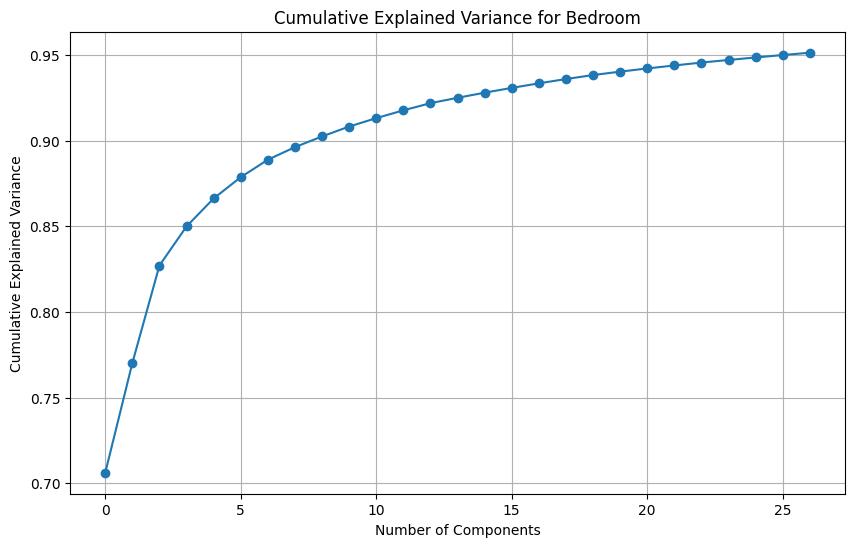

Category: Forest
Explained Variance Ratio: [5.25347951e-01 4.65008987e-02 3.98493190e-02 1.70631457e-02
 1.42324548e-02 1.35086942e-02 8.67335183e-03 7.70273598e-03
 7.27557764e-03 7.00224373e-03 5.60159820e-03 4.89850219e-03
 4.67663678e-03 4.56243439e-03 4.17293321e-03 3.90219210e-03
 3.47443821e-03 3.37185039e-03 3.19553210e-03 3.09216413e-03
 2.93980539e-03 2.77372751e-03 2.57113887e-03 2.50517927e-03
 2.45357802e-03 2.38520364e-03 2.20900369e-03 2.20224673e-03
 2.14441846e-03 2.04735478e-03 2.01802118e-03 1.95478045e-03
 1.85028635e-03 1.77780588e-03 1.74580787e-03 1.68501530e-03
 1.66916642e-03 1.63833996e-03 1.61350176e-03 1.59364358e-03
 1.53313202e-03 1.50653309e-03 1.43525612e-03 1.43004578e-03
 1.41688831e-03 1.37880301e-03 1.35123993e-03 1.33993722e-03
 1.31733168e-03 1.28125296e-03 1.27293946e-03 1.22616472e-03
 1.22070817e-03 1.20063961e-03 1.17716408e-03 1.14767195e-03
 1.13738948e-03 1.12887538e-03 1.11364252e-03 1.10762242e-03
 1.08248733e-03 1.07812924e-03 1.05422118e

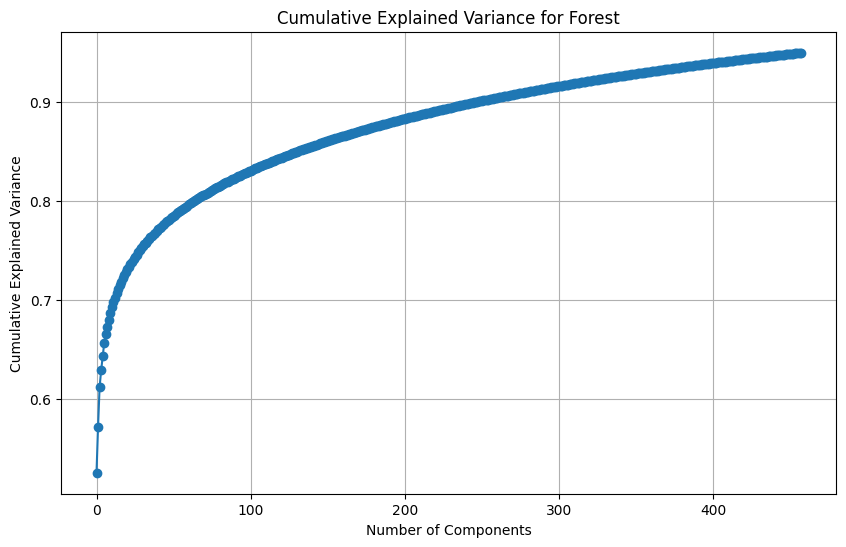

In [12]:
def print_explained_variance_ratio(pca_by_category):
    for category, pca in pca_by_category.items():
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
        print(f"Category: {category}")
        print(f"Explained Variance Ratio: {explained_variance_ratio}")
        print(f"Cumulative Explained Variance: {cumulative_explained_variance}")

        # Verificar se a variância explicada cumulativa atinge 0.99
        if np.any(cumulative_explained_variance >= 0.99):
            num_components_99 = np.where(cumulative_explained_variance >= 0.99)[0][0] + 1
            print(f"Number of components to explain 99% variance: {num_components_99}")
        else:
            max_cumulative_variance = cumulative_explained_variance[-1]
            print(f"Cumulative explained variance does not reach 99% with the given number of components. Maximum cumulative explained variance is: {max_cumulative_variance:.5f}")

        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_explained_variance, marker='o')
        plt.title(f'Cumulative Explained Variance for {category}')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()

# Print explained variance ratio and plot cumulative explained variance
print_explained_variance_ratio(pca_by_category)

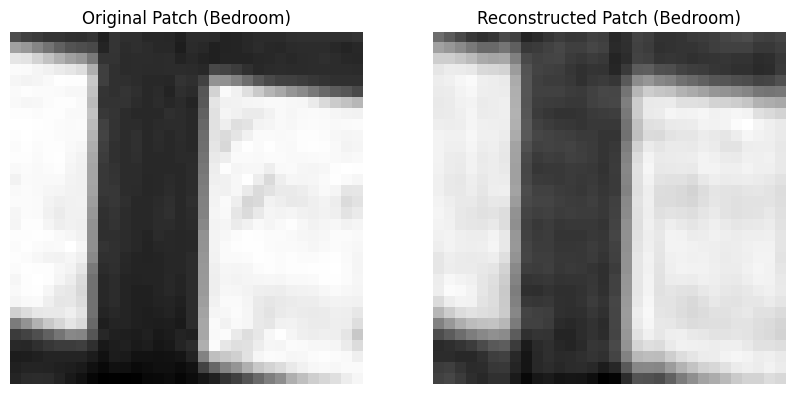

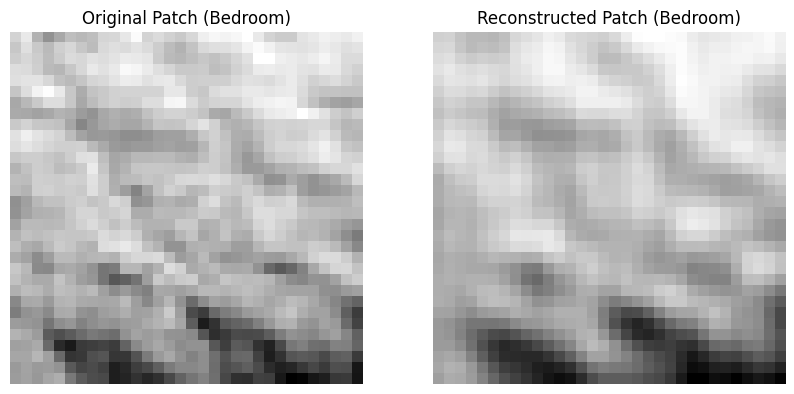

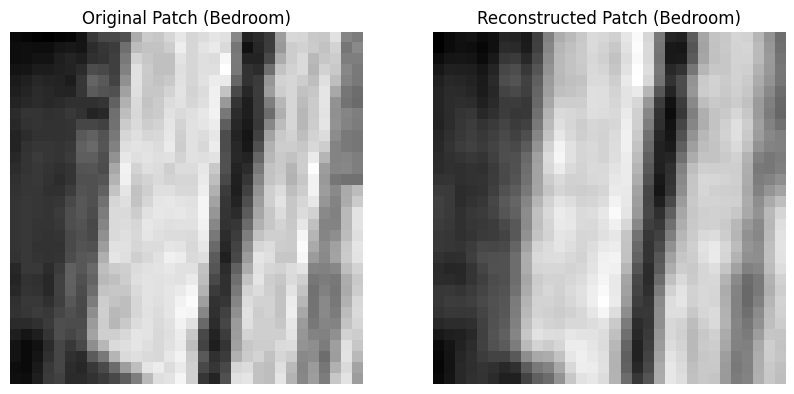

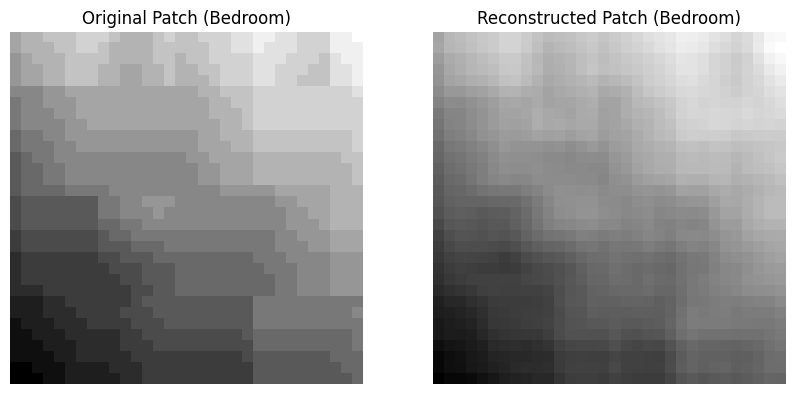

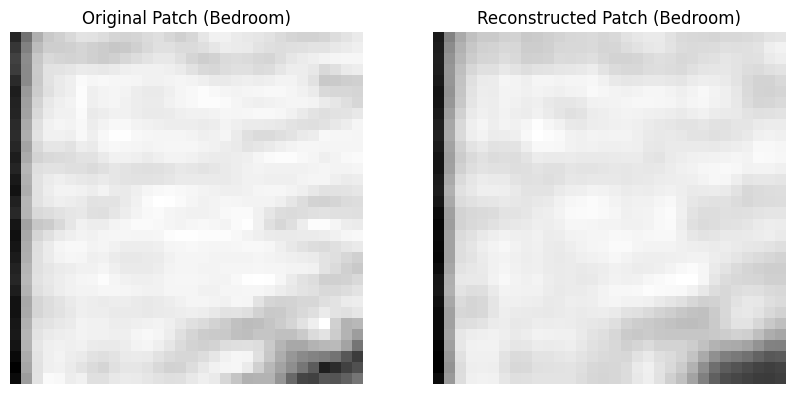

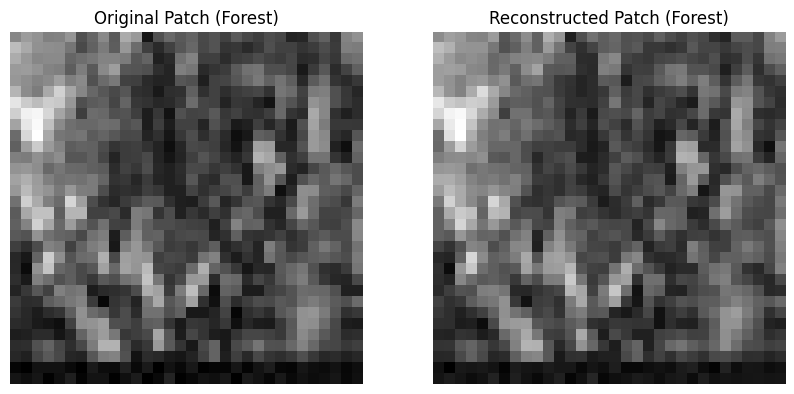

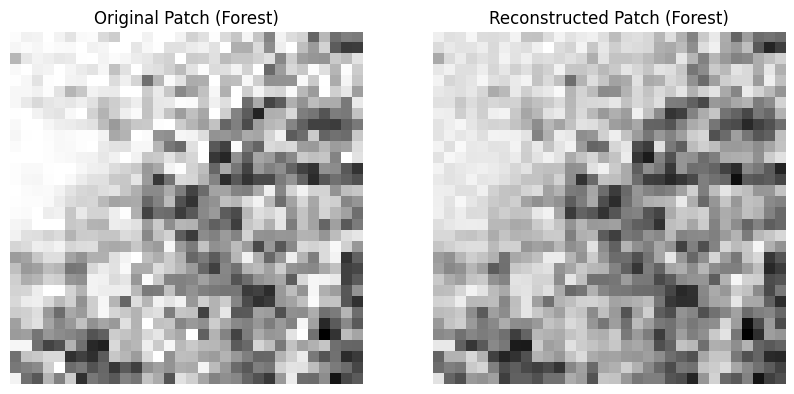

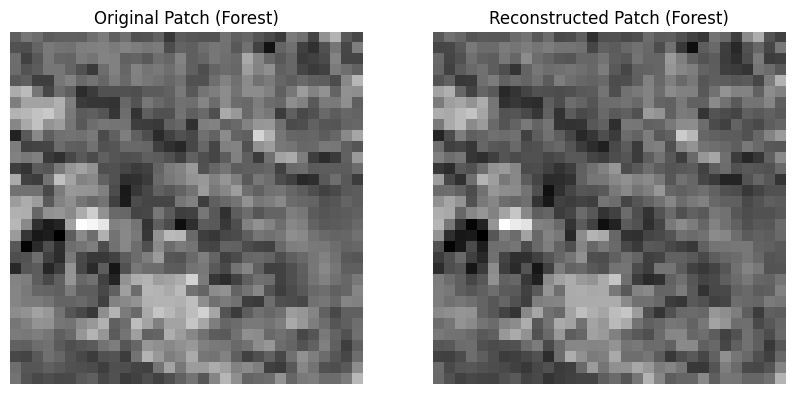

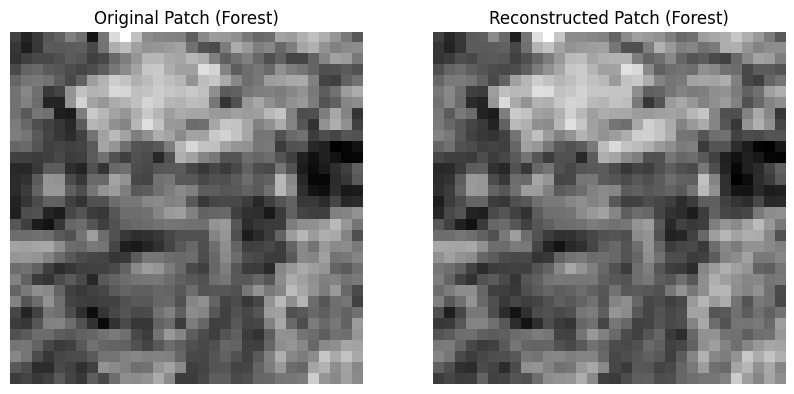

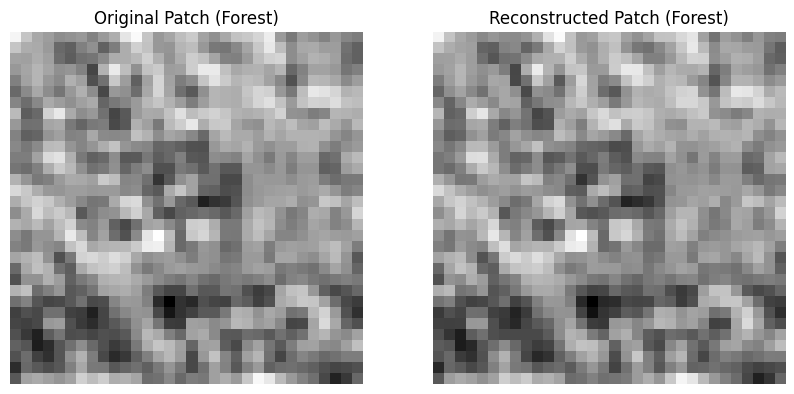

In [31]:
def visualize_reconstructed_images(pca_by_category, patches_by_category, n_samples=5):
    for category, pca in pca_by_category.items():
        category_name = str(category)
        patches = patches_by_category[category]
        
        # Randomly select a few samples
        sample_indices = np.random.choice(patches.shape[0], n_samples, replace=False)
        for idx in sample_indices:
            original_patch = patches[idx].reshape(32, 32)
            reconstructed_patch = pca.inverse_transform(pca.transform(patches[idx].reshape(1, -1))).reshape(32, 32)
            
            plt.figure(figsize=(10, 5))
            
            # Original patch
            plt.subplot(1, 2, 1)
            plt.imshow(original_patch, cmap='gray')
            plt.title(f'Original Patch ({category_name})')
            plt.axis('off')
            
            # Reconstructed patch
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_patch, cmap='gray')
            plt.title(f'Reconstructed Patch ({category_name})')
            plt.axis('off')
            
            plt.show()

# Visualize original and reconstructed images
visualize_reconstructed_images(pca_by_category, patches_by_category)


In [14]:
# Function to compute residuals with PCA
def compute_residuals_with_pca(patches, pca):
    projected_data = pca.transform(patches)
    reconstructed_data = pca.inverse_transform(projected_data)
    residuals = patches - reconstructed_data
    return residuals, reconstructed_data

In [32]:
# Extrair dados do primeiro ambiente (Bedroom)
first_environment = 'Bedroom'
first_environment_patches = normalized_patches_by_category[first_environment]
first_environment_pca = pca_by_category[first_environment]

# Extrair dados do segundo ambiente (Forest)
second_environment = 'Forest'
second_environment_pca = pca_by_category[second_environment]

In [36]:
# Function to calculate OOD metric
def calculate_ood_metric(residuals, reconstructed_patches):
    norm_residuals = np.linalg.norm(residuals, axis=1)
    norm_reconstructed = np.linalg.norm(reconstructed_patches, axis=1)
    ood_metric = norm_residuals / norm_reconstructed
    return ood_metric

# Function to determine the environment with PCA
def determine_environment(test_patches, pca_by_category, scalers_by_category):
    ood_scores = {}
    for category, pca in pca_by_category.items():
        scaler = scalers_by_category[category]
        test_patches_normalized, _ = normalize_patches(test_patches, scaler)
        residuals, reconstructed_patches = compute_residuals_with_pca(test_patches_normalized, pca)
        if residuals.size == 0 or reconstructed_patches.size == 0:
            print(f"Empty residuals or reconstructed_patches for category: {category}")
            continue
        ood_metric = calculate_ood_metric(residuals, reconstructed_patches)
        if len(ood_metric) > 0:
            ood_scores[category] = np.mean(ood_metric)
        else:
            print(f"No OOD metric calculated for category: {category}")
    if not ood_scores:
        raise ValueError("No valid OOD scores found.")
    best_environment = min(ood_scores, key=ood_scores.get)
    return best_environment, ood_scores


In [17]:
test_patches_by_category = load_patches_by_category('patches_test', y, patch_size)

In [37]:
patches_bedroom = test_patches_by_category['Bedroom']
patches_Forest = test_patches_by_category['Forest']

#Normalizar os patches
normalized_patches_bedroom = normalize_patches(patches_bedroom)
normalized_patches_Forest= normalize_patches(patches_Forest)

In [38]:
# Calcular a métrica OOD para os patches de teste
ood_metrics = {}
for test_category, test_patches in test_patches_by_category.items():
    best_environment, ood_scores = determine_environment(test_patches, pca_by_category, scalers_by_category)
    ood_metrics[test_category] = {'best_environment': best_environment, 'ood_scores': ood_scores}

# Imprimir os resultados
for test_category, results in ood_metrics.items():
    print(f"Test category: {test_category}")
    print(f"Best environment: {results['best_environment']}")
    print(f"OOD scores: {results['ood_scores']}")

Test category: Bedroom
Best environment: Forest
OOD scores: {'Bedroom': 0.10560936152166288, 'Forest': 0.01839441554037858}
Test category: Forest
Best environment: Forest
OOD scores: {'Bedroom': 0.4244591528739208, 'Forest': 0.1028712495826563}


In [43]:
from collections import Counter

# Categorize test images
def categorize_test_images(test_patches, pca_by_category, scalers_by_category):
    categories = list(pca_by_category.keys())
    predictions = []
    for test_patch in test_patches:
        min_error = float('inf')
        best_category = None
        for category in categories:
            scaler = scalers_by_category[category]
            test_patch_normalized = scaler.transform(test_patch.reshape(1, -1))
            residuals = compute_residuals_with_pca(test_patch_normalized, pca_by_category[category])
            reconstruction_error = np.linalg.norm(residuals)
            if reconstruction_error < min_error:
                min_error = reconstruction_error
                best_category = category
        predictions.append(best_category)
    return predictions

def determine_final_category(predictions):
    category_count = Counter(predictions)
    final_category = category_count.most_common(1)[0][0]
    return final_category

In [44]:
# Categorize test images and print results
for test_category, test_patches in test_patches_by_category.items():
    predictions = categorize_test_images(test_patches, pca_by_category, scalers_by_category)
    final_category = determine_final_category(predictions)
    print(f"Test category: {test_category}")
    print(f"Predictions: {predictions}")
    print(f"Final category: {final_category}")


Test category: Bedroom
Predictions: ['Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Forest', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Forest', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Bedroom', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Forest', 'Forest', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Bedroom', 'Bedroom', 'Forest', 'Forest', 'Forest', 'Forest', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Forest', 'Bedroom', 'Forest', 'Forest', 'Forest', 'Be

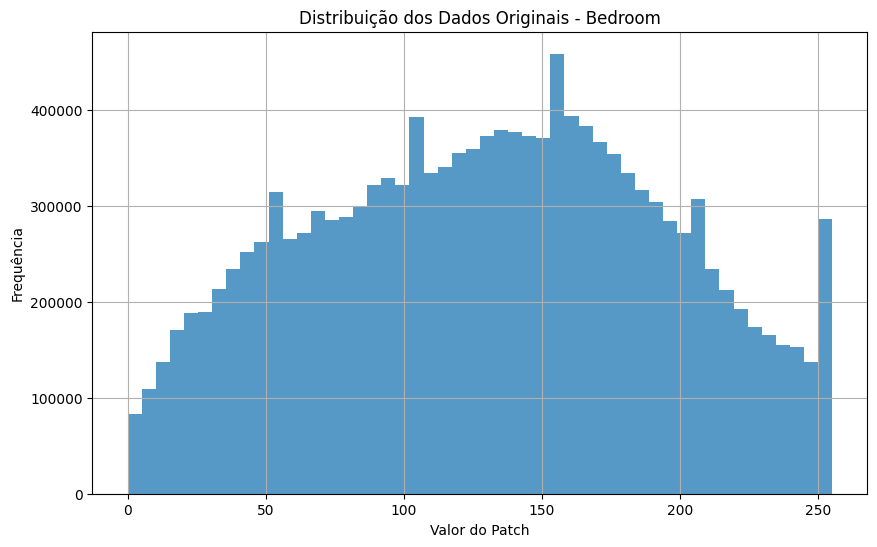

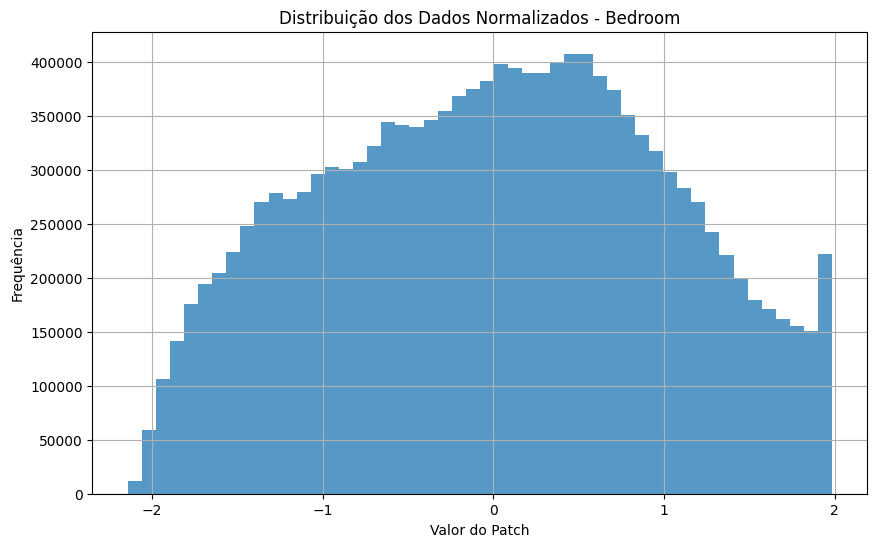

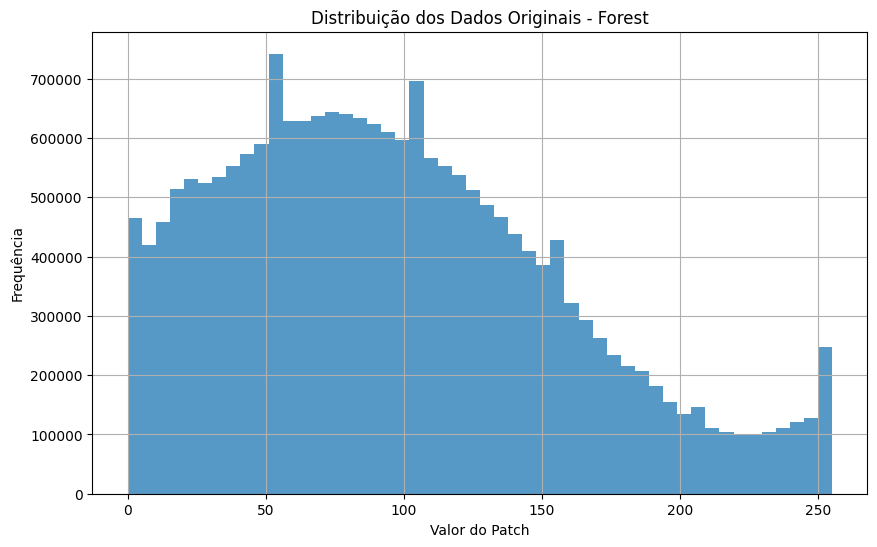

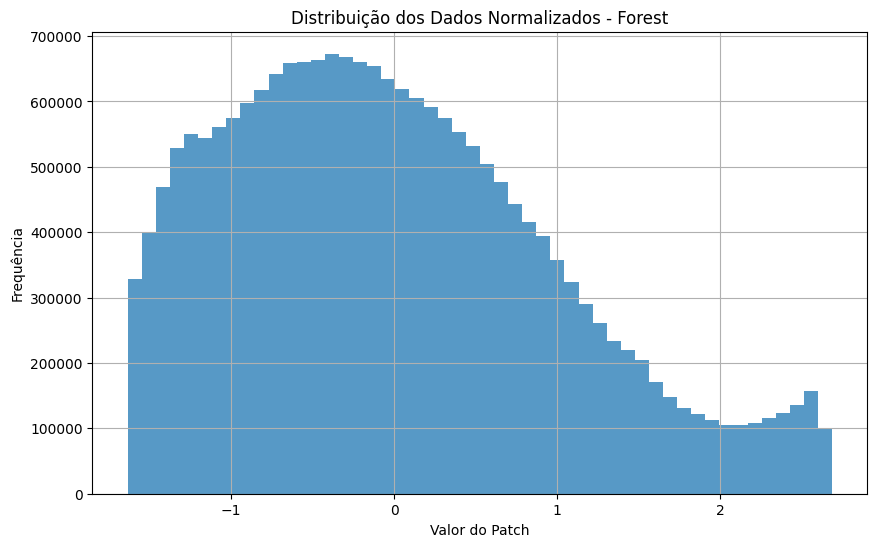

In [20]:
import matplotlib.pyplot as plt

def plot_distribution(patches, title):
    plt.figure(figsize=(10, 6))
    plt.hist(patches.flatten(), bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Valor do Patch')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

# Exemplo de uso
for category, patches in patches_by_category.items():
    plot_distribution(patches, f'Distribuição dos Dados Originais - {category}')
    normalized_patches, _ = normalize_patches(patches)
    plot_distribution(normalized_patches, f'Distribuição dos Dados Normalizados - {category}')


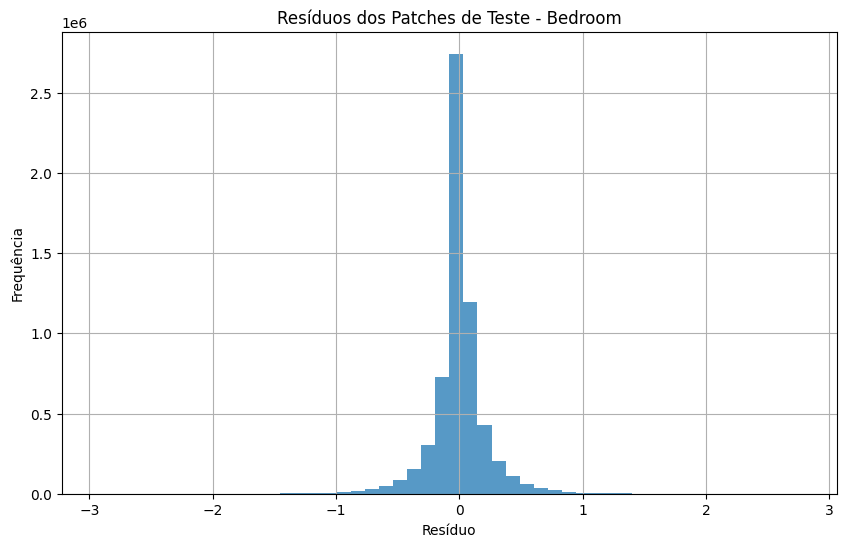

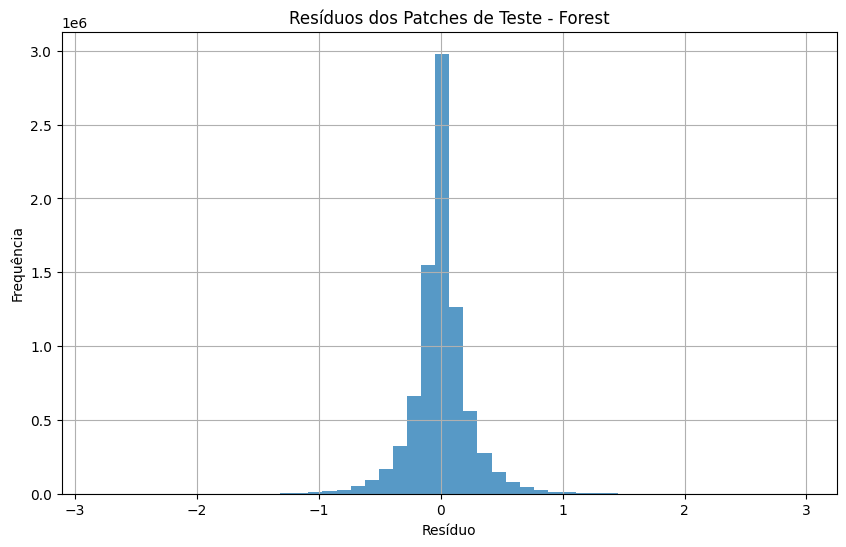

In [22]:
def plot_residuals(residuals, title):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals.flatten(), bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

# Exemplo de uso
for test_category, test_patches in test_patches_by_category.items():
    _, scaler = normalize_patches(test_patches, scalers_by_category[test_category])
    test_patches_normalized, _ = normalize_patches(test_patches, scaler)
    residuals, reconstructed = compute_residuals_with_pca(test_patches_normalized, pca_by_category[test_category])
    plot_residuals(residuals, f'Resíduos dos Patches de Teste - {test_category}')


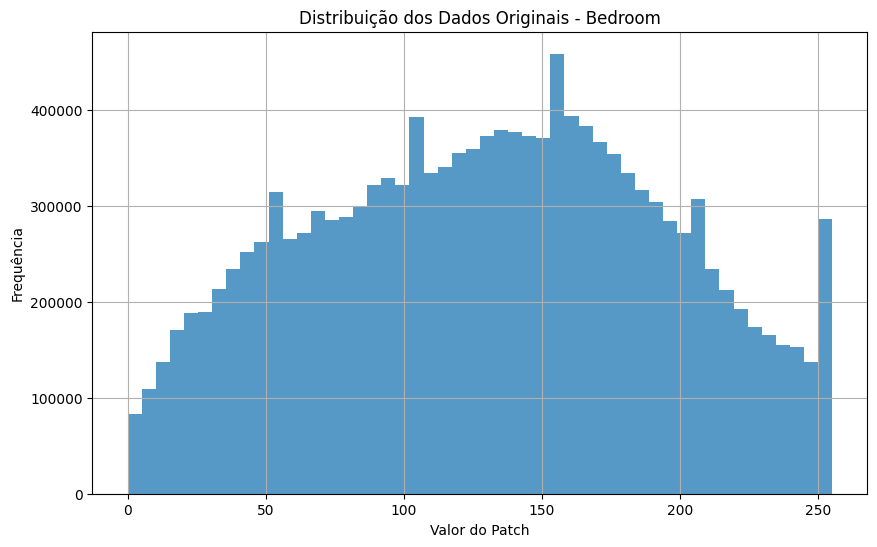

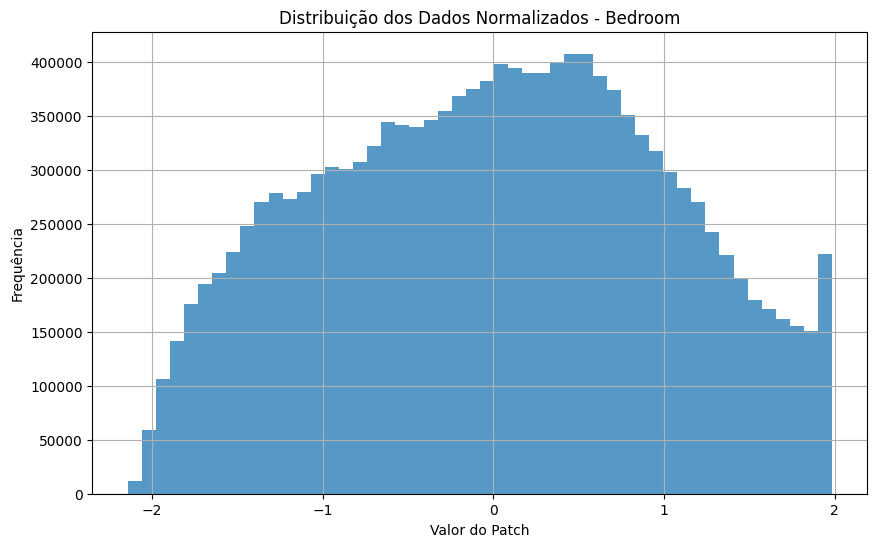

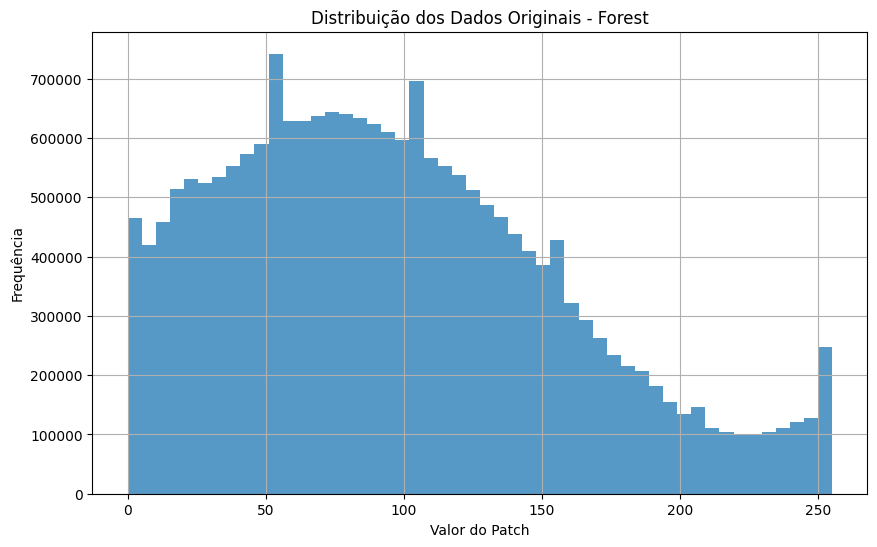

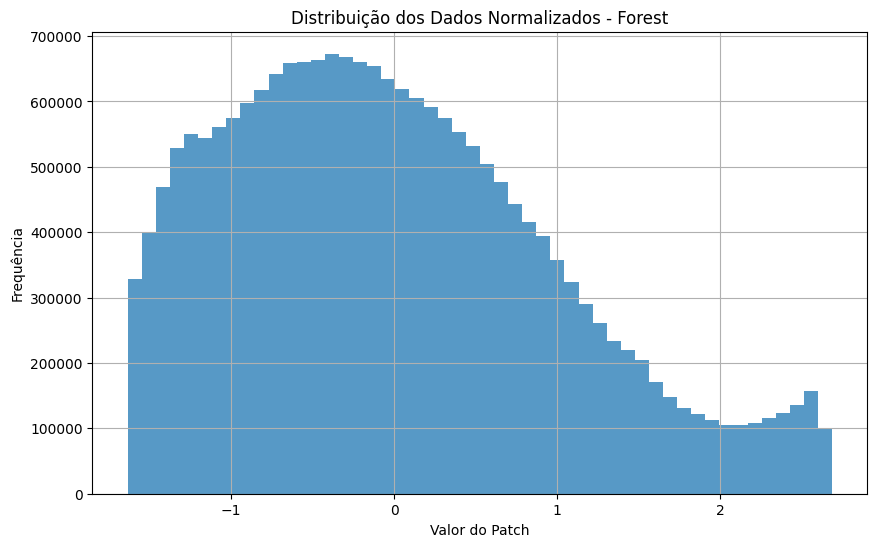

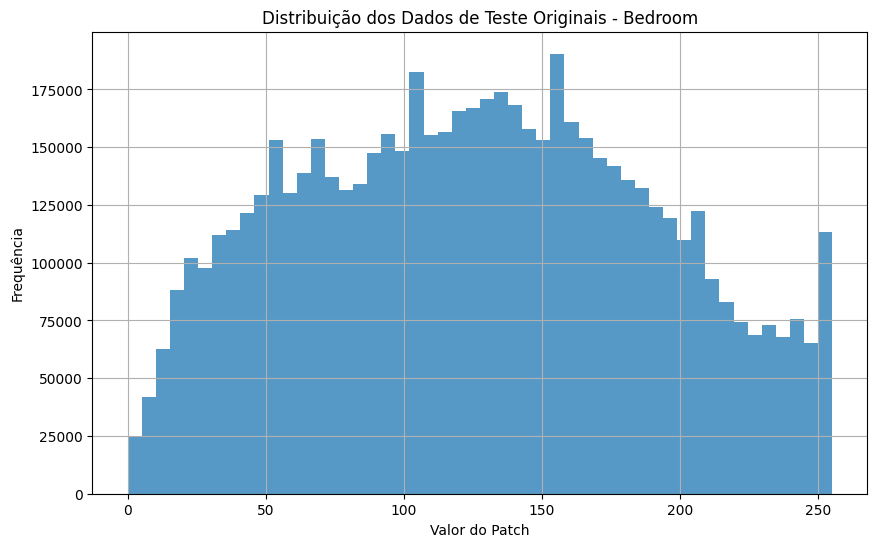

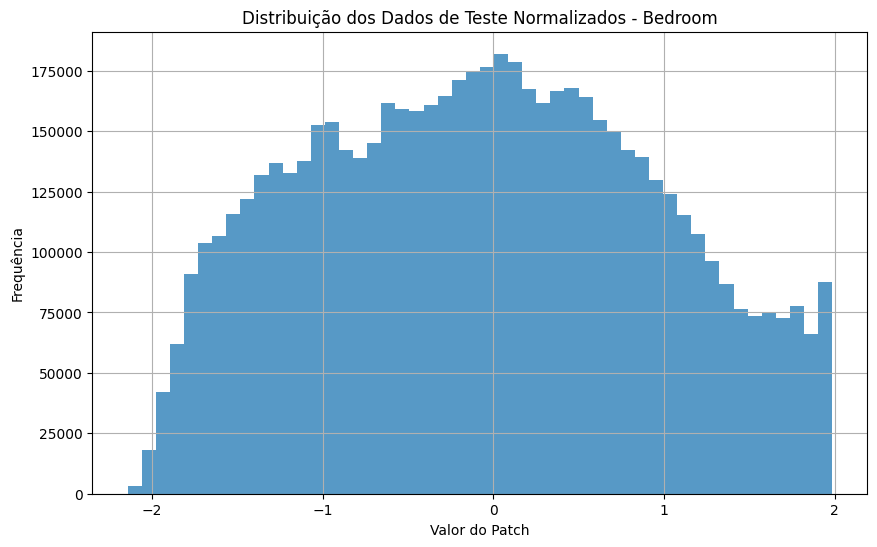

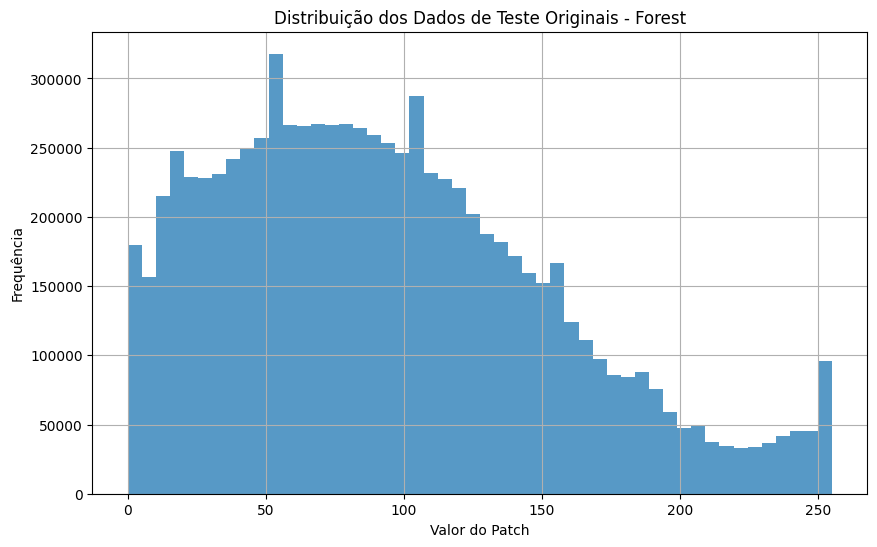

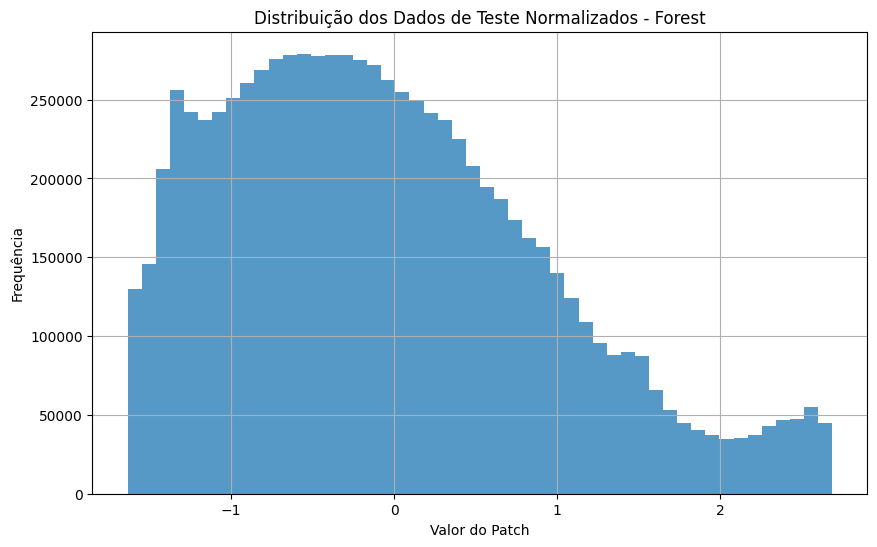

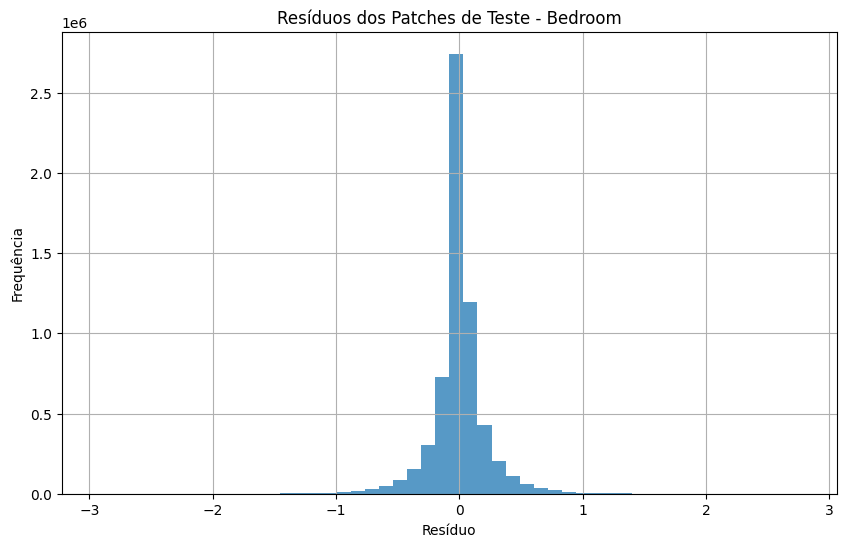

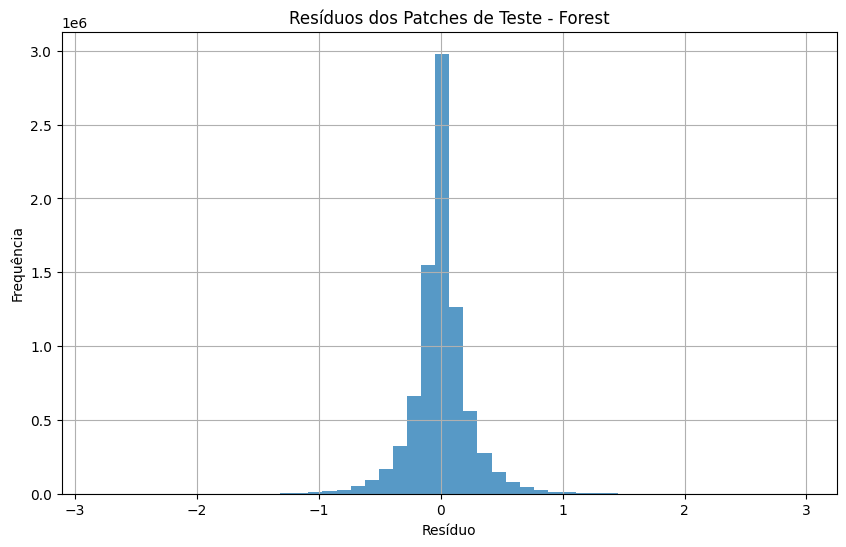

In [24]:
# Verificar a normalização dos dados de treino
for category, patches in patches_by_category.items():
    normalized_patches, scaler = normalize_patches(patches)
    plot_distribution(patches, f'Distribuição dos Dados Originais - {category}')
    plot_distribution(normalized_patches, f'Distribuição dos Dados Normalizados - {category}')

# Verificar a normalização dos dados de teste
for test_category, test_patches in test_patches_by_category.items():
    scaler = scalers_by_category[test_category]
    test_patches_normalized, _ = normalize_patches(test_patches, scaler)
    plot_distribution(test_patches, f'Distribuição dos Dados de Teste Originais - {test_category}')
    plot_distribution(test_patches_normalized, f'Distribuição dos Dados de Teste Normalizados - {test_category}')

# Verificar a reconstrução do PCA
for test_category, test_patches in test_patches_by_category.items():
    scaler = scalers_by_category[test_category]
    test_patches_normalized, _ = normalize_patches(test_patches, scaler)
    residuals, reconstructed = compute_residuals_with_pca(test_patches_normalized, pca_by_category[test_category])
    plot_residuals(residuals, f'Resíduos dos Patches de Teste - {test_category}')


category: Bedroom
norm residuals = [2.46201549 6.87864518 2.18415463 ... 0.35822348 0.99677296 2.90890556]
norm reconstructed = [14.63906059 30.01572934 49.75169927 ... 48.88485398 13.76219185
 22.46226736]
ood = [0.16818125 0.22916802 0.04390111 ... 0.0073279  0.07242836 0.12950187]
category: Forest
norm residuals = [0.69762107 1.95321546 0.34056736 ... 0.23719201 0.31277671 0.68025623]
norm reconstructed = [28.9220891  38.18967092 34.84223204 ... 69.11996994 31.6217308
 17.69705961]
ood = [0.0241207  0.05114512 0.00977456 ... 0.0034316  0.0098912  0.03843894]


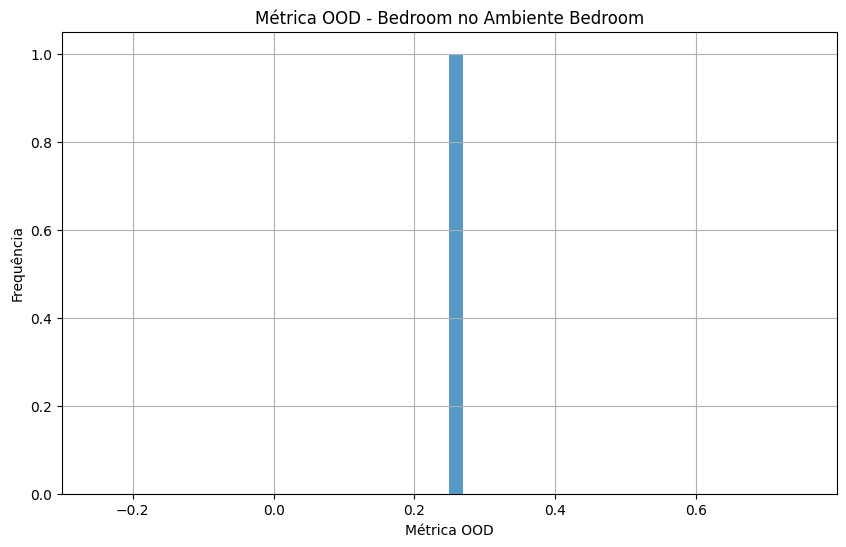

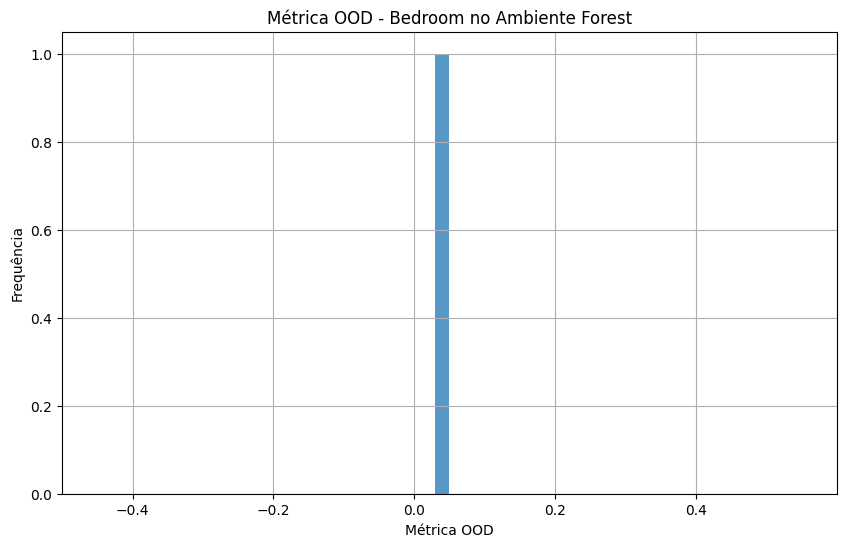

category: Bedroom
norm residuals = [11.18287844 14.90833683 12.95591014 ... 10.82332662  4.94856759
  9.45863971]
norm reconstructed = [26.18698413 33.67948105 27.5331357  ... 42.16973858 59.5808822
 30.20277108]
ood = [0.42703957 0.4426534  0.47055701 ... 0.25666098 0.0830563  0.31317125]
category: Forest
norm residuals = [2.91129792 3.16856832 3.0851284  ... 5.13779894 2.03338483 4.32698494]
norm reconstructed = [20.55893753 31.4651363  46.43921402 ... 29.80121983 45.31994902
 19.03848701]
ood = [0.14160741 0.10070092 0.06643369 ... 0.1724023  0.04486732 0.22727567]


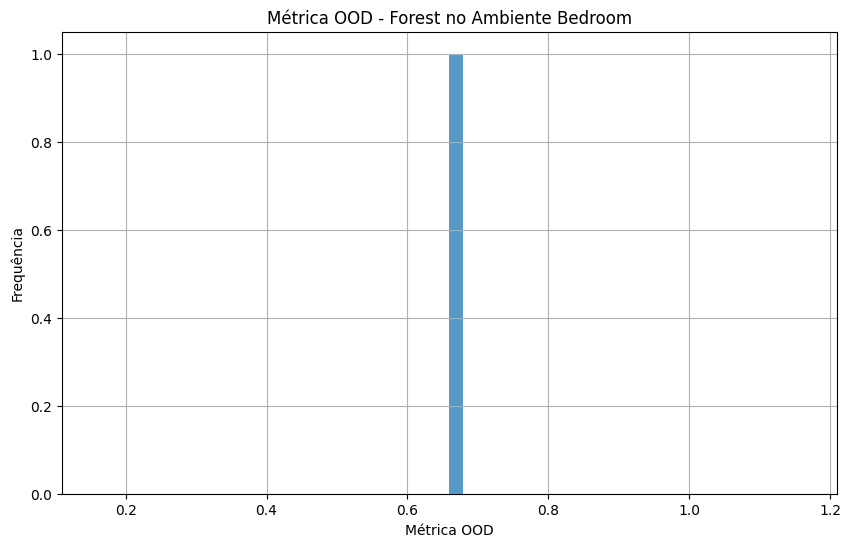

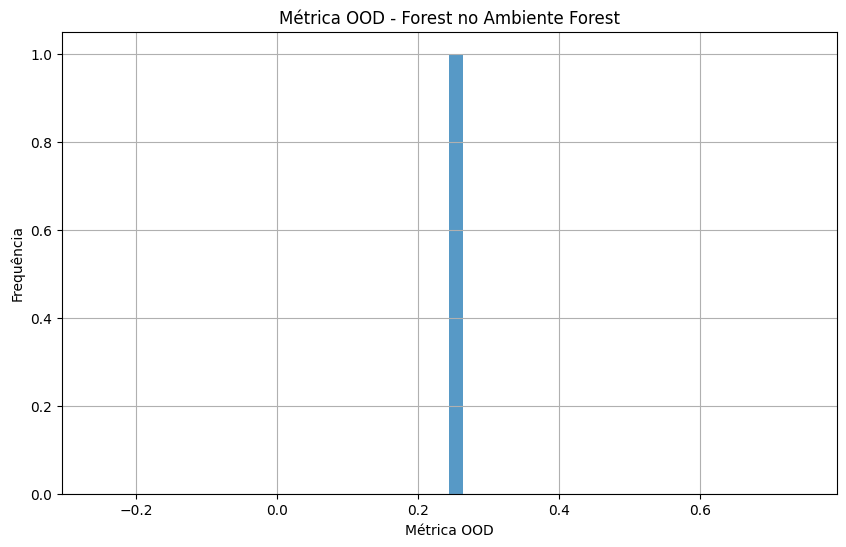

In [25]:
def plot_ood_metric(ood_metrics, title):
    plt.figure(figsize=(10, 6))
    plt.hist(ood_metrics, bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Métrica OOD')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

# Exemplo de uso
for test_category, test_patches in test_patches_by_category.items():
    best_environment, ood_scores = determine_environment(test_patches, pca_by_category, scalers_by_category)
    for environment, ood_metric in ood_scores.items():
        plot_ood_metric(ood_metric, f'Métrica OOD - {test_category} no Ambiente {environment}')


category: Bedroom
norm residuals = [2.46201549 6.87864518 2.18415463 ... 0.35822348 0.99677296 2.90890556]
norm reconstructed = [14.63906059 30.01572934 49.75169927 ... 48.88485398 13.76219185
 22.46226736]
ood = [0.16818125 0.22916802 0.04390111 ... 0.0073279  0.07242836 0.12950187]
category: Forest
norm residuals = [0.69762107 1.95321546 0.34056736 ... 0.23719201 0.31277671 0.68025623]
norm reconstructed = [28.9220891  38.18967092 34.84223204 ... 69.11996994 31.6217308
 17.69705961]
ood = [0.0241207  0.05114512 0.00977456 ... 0.0034316  0.0098912  0.03843894]


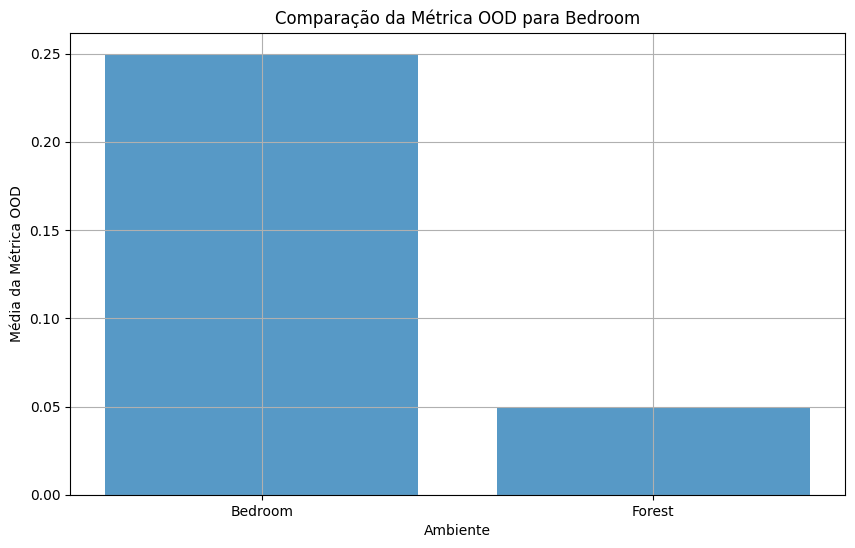

category: Bedroom
norm residuals = [11.18287844 14.90833683 12.95591014 ... 10.82332662  4.94856759
  9.45863971]
norm reconstructed = [26.18698413 33.67948105 27.5331357  ... 42.16973858 59.5808822
 30.20277108]
ood = [0.42703957 0.4426534  0.47055701 ... 0.25666098 0.0830563  0.31317125]
category: Forest
norm residuals = [2.91129792 3.16856832 3.0851284  ... 5.13779894 2.03338483 4.32698494]
norm reconstructed = [20.55893753 31.4651363  46.43921402 ... 29.80121983 45.31994902
 19.03848701]
ood = [0.14160741 0.10070092 0.06643369 ... 0.1724023  0.04486732 0.22727567]


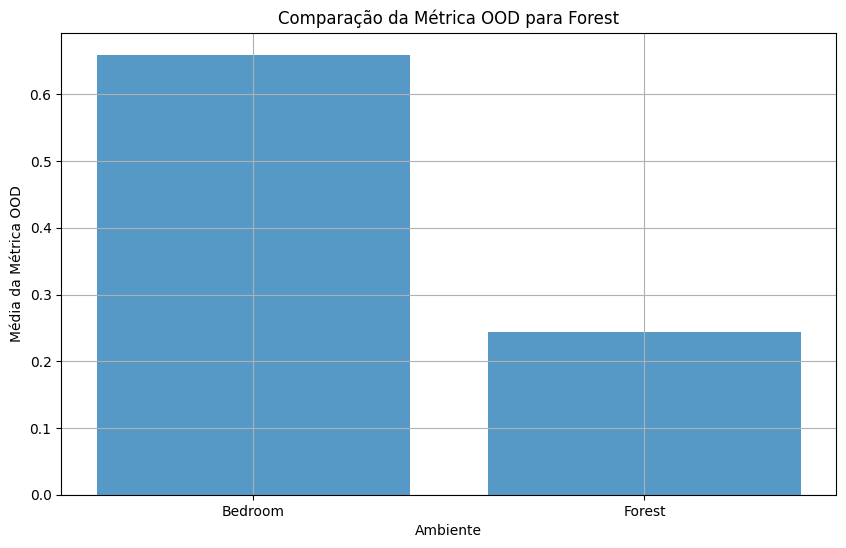

In [26]:
def plot_ood_comparison(ood_scores, test_category):
    categories = list(ood_scores.keys())
    scores = list(ood_scores.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, scores, alpha=0.75)
    plt.title(f'Comparação da Métrica OOD para {test_category}')
    plt.xlabel('Ambiente')
    plt.ylabel('Média da Métrica OOD')
    plt.grid(True)
    plt.show()

# Exemplo de uso
for test_category, test_patches in test_patches_by_category.items():
    best_environment, ood_scores = determine_environment(test_patches, pca_by_category, scalers_by_category)
    plot_ood_comparison(ood_scores, test_category)


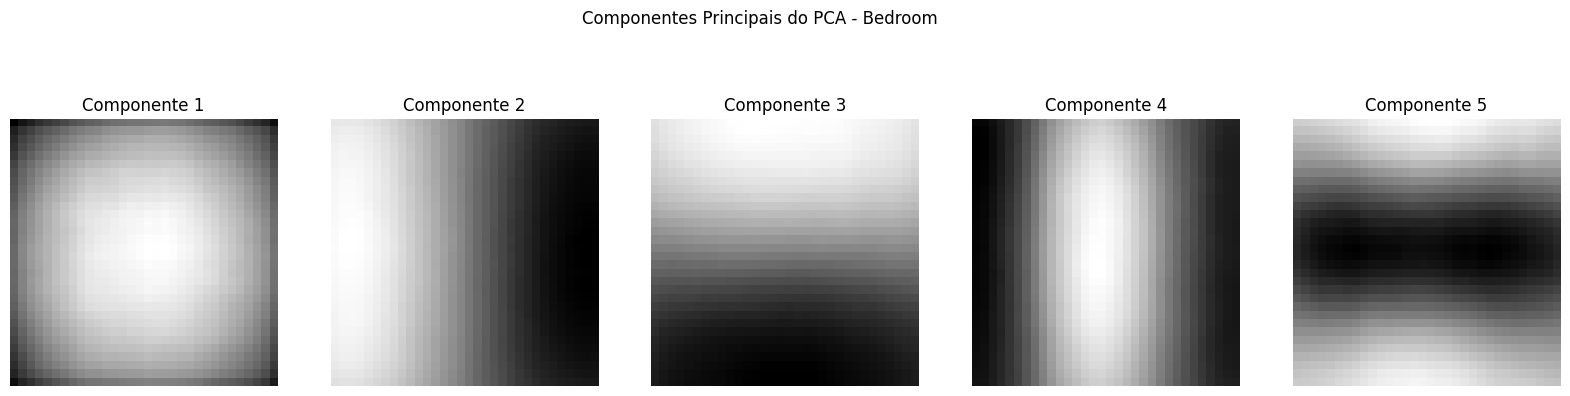

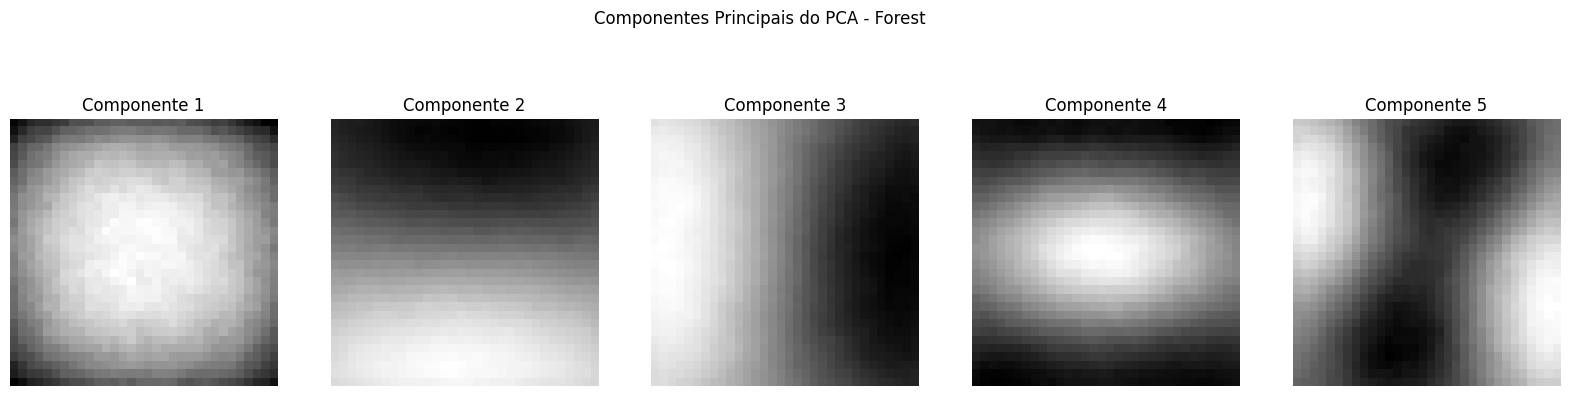

In [27]:
def plot_pca_components(pca, title, n_components=5):
    fig, axes = plt.subplots(1, n_components, figsize=(20, 5))
    for i, ax in enumerate(axes):
        component = pca.components_[i].reshape(32, 32)  # Supondo que cada patch é de 32x32 pixels
        ax.imshow(component, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Componente {i+1}')
    plt.suptitle(title)
    plt.show()

# Exemplo de uso
for category, pca in pca_by_category.items():
    plot_pca_components(pca, f'Componentes Principais do PCA - {category}')


# Using Kernel PCA

In [28]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
